In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import urllib.request
from keras.optimizers import adam_v2
import ssl
import os
import matplotlib.pyplot as plt

In [2]:
# Define the input image size
img_width, img_height = 224, 224

# Set the number of epochs and batch size
epochs = 20
batch_size = 32

In [3]:
# Set the path to the dataset 
train_dir = '/Volumes/SSD/dishes'
valid_dir = '/Volumes/SSD/dishes-val'
test_dir = '/Volumes/SSD/dishes-test'

In [4]:
# Create a data generator for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Create a data generator for the validation set
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')

Found 1985 images belonging to 2 classes.
Found 833 images belonging to 2 classes.


In [5]:
# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
# Load InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add a GlobalAveragePooling2D layer to convert the output of the previous layer into a 2D tensor
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout layer with a rate of 0.5 to prevent overfitting
x = Dropout(0.5)(x)

# Add a final binary classification layer with sigmoid activation
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer=adam_v2.Adam(learning_rate=0.0001, decay=0.0001/epochs), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator)

Epoch 1/20
63/63 [==============================] - 200s 3s/step - loss: 0.6330 - accuracy: 0.6630 - val_loss: 0.5796 - val_accuracy: 0.6891
Epoch 2/20
63/63 [==============================] - 161s 3s/step - loss: 0.4566 - accuracy: 0.7854 - val_loss: 0.5726 - val_accuracy: 0.7083
Epoch 3/20
63/63 [==============================] - 162s 3s/step - loss: 0.4482 - accuracy: 0.7844 - val_loss: 0.5593 - val_accuracy: 0.7131
Epoch 4/20
63/63 [==============================] - 160s 3s/step - loss: 0.4150 - accuracy: 0.8106 - val_loss: 0.5521 - val_accuracy: 0.7227
Epoch 5/20
63/63 [==============================] - 160s 3s/step - loss: 0.3824 - accuracy: 0.8338 - val_loss: 0.5607 - val_accuracy: 0.7239
Epoch 6/20
63/63 [==============================] - 160s 3s/step - loss: 0.3618 - accuracy: 0.8529 - val_loss: 0.5485 - val_accuracy: 0.7359
Epoch 7/20
63/63 [==============================] - 159s 3s/step - loss: 0.3433 - accuracy: 0.8539 - val_loss: 0.5522 - val_accuracy: 0.7323
Epoch 8/20
63

In [10]:
# Evaluate the model
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Found 2321 images belonging to 2 classes.
73/73 [==============================] - 125s 2s/step - loss: 0.6490 - accuracy: 0.7234
Test accuracy: 0.7233951091766357


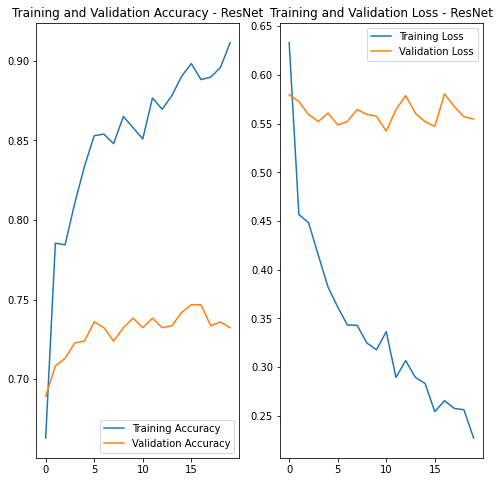

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - ResNet')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - ResNet')
plt.show()